In [1]:
from google.colab import drive ##
drive.mount('/content/drive')  ## Choose the Google account whose Drive you want to mount --> "Sign in to Google Drive for desktop" --> "Make sure you trust Google Drive for desktop" (you must allow Google Drive to access your data for use in the program)
%cd 'drive/MyDrive/Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks




---



## If you want to upload a file, execute the following cell


In [ ]:
### Execute this cell only if you want to upload a file
from google.colab import files
uploaded = files.upload()



---



## In the "Runtime" menu select "Run the focused cell" or SHIFT+Enter in the following cells

In [2]:
%ls ## check that your data file is located in this directory

 01_eda_with_python.ipynb
 02_regression_with_python.ipynb
 1982NSFGData.dat.gz
 1995FemRespData.dat.gz
 2002FemPreg.dat.gz
 2002FemPreg.dct
 2002FemResp.dat.gz
 2002FemResp.dct
 2002Male.dat.gz
 2002Male.dct
 2006_2010_FemPreg.dat.gz
 2006_2010_FemPregSetup.dct
 2006_2010_FemResp.dat.gz
 2006_2010_FemRespSetup.dct
 2006_2010_Male.dat.gz
 2006_2010_MaleSetup.dct
 2011_2013_FemPregData.dat.gz
 2011_2013_FemPregSetup.dct
 2011_2013_FemRespData.dat.gz
 2011_2013_FemRespSetup.dct
 2011_2013_MaleData.dat.gz
 2011_2013_MaleSetup.dct
 analytic.py
 Apr25_27thAn_set1.shtml
 Aula_1bach@
 babyboom.dat
'Basic_Plotting (1).ipynb'
 Basic_Plotting.ipynb
 brfss.py
 build.sh
'Carrera de tortugas.ipynb'
 CDBRFS08.ASC.gz
 CDBRFS08ASC.ZIP
 chap01ex.ipynb
 chap01ex.py
 chap01soln.py
 chap02ex.ipynb
 chap02ex.py
 chap02soln.py
 chap03ex.ipynb
 chap03soln.py
 chap04ex.ipynb
 chap05ex.ipynb
 chap06ex.ipynb
 chap06soln.py
 chap07ex.ipynb
 chap07soln.py
 chap08ex.ipynb
 chap08soln.py
 chap09ex.ipynb
 chap09soln

In [3]:
filename = input("Excel filename:")

Excel filename:data_example.xlsx


In [4]:
n_sheets = input("Number of sheets in the Excel File (number of time points):")

Number of sheets in the Excel File (number of time points):4


## Now you can select “*Execute cell and following cells*” in the “Runtime” menu (or press *CRTL*+F10) to execute all cells and see the result in the last cell, or execute cell by cell by pressing *SHIFT*+ENTER in each cell


In [14]:
# Import necessary libraries

# Data organization
import pandas as pd
import numpy as np

# Data visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Modeling
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import norm

In [6]:
def read_file_ntimes (file, ntimes):
    """
    Funtion to read multiple sheets from an Excel file and organize them into a list of DataFrames.

    Parameters:
    file : str
        The file path or name of the Excel file containing the data. The file should contain multiple sheets,
        each representing consecutive time points (e.g., 0 hours, 24 hours, 48 hours).

    ntimes : int
        The number of sheets to read from the Excel file, representing different time points.

    Expected Excel File Format:
    - Each sheet in the file should have the following column structure:
      - 1st column: "Concentration" in micromolar (µM).
      - Columns 2 onward: Data for replicates of different experiments in the following sequence:
        - Columns 2–4: Replicate 1, Replicate 2, Replicate 3 for Experiment 1.
        - Columns 5–7: Replicate 1, Replicate 2, Replicate 3 for Experiment 2.
        - Continue this pattern for additional experiments.

    Returns:
    list of pandas.DataFrame
        A list containing DataFrames for each time point (sheet) in the Excel file.
    """

    DF_list = list()
    sheets = range(ntimes) # Reads the specified number of sheets

    # Loop to process all sheets
    for sheet in sheets:
        print('sheet:', sheet)
        df = pd.read_excel(file, sheet_name=sheet) ## selelct decimal (point decimal='.')
        cols = df.columns
        df.set_index(cols[0], inplace=True) # Set the first column (concentration) as the index
        print('Data:\n',df)
        # Fill NaN values with the mean of replicates
        df_filled = df.T.fillna(df.mean(axis=1)).T

        # Add the processed DataFrame to the list
        DF_list.append(df_filled)

    return DF_list

In [7]:
def log_absorbance_data(dfs):
    """
    Compute the logarithm of absorbance data for each experiment and time point.

    Assumes columns for replicates are located consecutively for each experiment.
    The total number of columns (excluding the concentration column) is:
        Number of replicates × Number of experiments

    Parameters:
    dfs : list of pandas.DataFrame
        A list of DataFrames, each representing data from a different time point. Each DataFrame should have:
        - 1st column: "Concentration".
        - Subsequent columns: Data for replicates of different experiments, with columns for replicates grouped together sequentially.

    Returns:
    tuple
        - Concentr: A NumPy array of concentration values (extracted from the index of the DataFrames).
        - logs_C_t: A 3D NumPy array with the logarithm of average absorbance values. The shape of the array is
          (number of concentrations, number of time points, number of experiments).
    """

    n_times = len(dfs) # Number of time points (DataFrames)
    shape = dfs[0].shape
    print('shape:', shape)
    n_exp = shape[-1] # Number of experiments (assuming 3 replicates per experiment)

    n_Conc = len(dfs[0].index) # Number of concentration levels
    Concentr = dfs[0].index.values # Array of concentration values

    print('n_times:', n_times, 'n_Conc:', n_Conc,'n_exp:', n_exp)

    # Initialize the array to hold logarithmic values
    logs_C_t = np.zeros((n_Conc, n_times, n_exp) )

    for i_C in range(n_Conc):
        for i_t in range(n_times):
            logs_C_t[i_C, i_t] = np.log(dfs[i_t].iloc[i_C,:].values)

    return Concentr, logs_C_t

In [8]:
def f_lin(x, a, b):
    """
    Computes a simple linear function.

    Parameters:
    x : float or np.ndarray
        The input value or array of values.
    a : float
        Slope of the linear function.
    b : float
        Intercept of the linear function.

    Returns:
    float or np.ndarray
        The computed value(s) of the linear function for the given input(s).
    """
    return  a*x + b

In [9]:
def calculate_growth_rate_bootstrap(X, y, n_boot, name, save=True):
    """
    Calculates the growth rate using the Bootstrap method by resampling the data, fitting a linear model,
    and averaging the results. The function also computes the 90% confidence interval for the growth rate.

    Parameters:
    X : array-like
        Input values representing the independent variable (e.g., time).
    y : array-like
        Dependent variable values (e.g., growth measurements).
    n_boot : int
        Number of Bootstrap iterations.
    name : str
        Name used for saving the plot (if `save=True`).
    save : bool, optional
        Whether to save the resulting plot as a file. Defaults to False.

    Returns:
    tuple
        - slope_mean: Mean of the growth rates obtained from Bootstrap iterations.
        - Interv_A: 90% confidence interval for the growth rate.
    """

    # Convert inputs to numpy arrays and flatten
    X0=np.array(X).ravel()
    y0=np.array(y).ravel()
    print('X:',X0)
    print('y:',y0)

    n_samples=len(X0)
    # print('n_samples:', n_samples)

    # Initialize parameters for plotting and Bootstrap iterations
    n_points = n_boot
    n_param = 2  # Number of parameters for linear fit
    alpha = 0.05  # For 95% confidence interval

    # Create a figure with subplots for plotting
    fig = plt.figure(figsize=(10,10))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    # Arrays to store results from Bootstrap iterations
    y_hat_b = np.zeros((n_boot, n_samples), dtype=float) # Fitted values for each Bootstrap sample
    params_b = np.zeros((n_boot, n_param), dtype=float) # Parameters for each Bootstrap fit
    r2_b = np.zeros((n_boot), dtype = float)  # R^2 values for each fit

    npoints_plot = 1000
    X_plot = np.linspace(0,X0[-1],npoints_plot)

    nfit=0
    i_fit=0

    for i in range(n_boot):
        # Bootstrap: sample data with replacement
        i_index = np.random.choice(range(0, len(X0)), len(X0))
        X_boot = X0[i_index]
        y_boot = y0[i_index]

        try:
            # Linear fit to the resampled data
            popt_b, pcov_b = curve_fit(f_lin, X_boot, y_boot)

            # Ensure parameters are within reasonable bounds
            if (np.abs(popt_b)<10).all() and (np.sqrt(pcov_b[0][0])<10):
                y_hat_i = f_lin(X_boot, *popt_b) # Predicted values for the resampled data
                y_hat_b[i_fit,:] = y_hat_i
                params_b[i_fit,:] = popt_b
                r2_b[i_fit] = r2_score(y_boot, y_hat_i)

                # Plot each fit line
                y_plot = f_lin(X_plot, *popt_b)
                ax1.plot(X_plot, y_plot, color='grey', alpha=0.1, zorder=1)
                plt.scatter(X_boot, y_boot, marker='o', color='orange', zorder=1)

                i_fit += 1

        except Exception as e:
            print(f'Error in curve_fit at iteration {i}: {e}')

    nfit = i_fit
    print('Number of successful fits:', nfit)

    # Calculate mean slope and its standard error
    params_mean = np.mean(params_b[:nfit,:], axis=0)
    slope_mean = params_mean[0]

    # Compute standard error of the slope
    sum_res2 = np.sum((params_b[:nfit,0] - slope_mean)**2)
    SE_A = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2 / (nfit-1))


    #############
    t = stats.t.ppf(0.95, n_samples-2) # Student's t-value for 90% confidence interval
    ### Aquí se podría sustituir el 0.95 por 1-alpha (alpha lo he quitado de una celda de más abajo y lo he puesto en esta)
    #############



    Interv_A = t * SE_A
    print('Mean slope:', slope_mean, '; 90% Confidence Interval:', Interv_A)

    # Plot results
    ymin_plot, ymax_plot = plt.ylim()
    xmin_plot, xmax_plot = plt.xlim()
    print('ymin', ymin_plot)
    ax1.margins(0.01)

    # Plot mean fit line and add legend
    ax1.plot(X_plot, f_lin(X_plot, params_mean[0], params_mean[1]),'r', linewidth=4,
             label="Slope={:.3f}; 90% CI ={:.3f}".format(slope_mean, Interv_A))
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('ln(N)')
    ax1.set_title(f'Growth Rate ({name}) - Bootstrap Results')
    ax1.grid(True)
    ax1.legend()


    n_bins=20

    # Histogram of R^2 values
    r2_plot = r2_b[:nfit].ravel()
    print('r^2_min:', r2_plot.min(), ';   resid_max:',r2_plot.max())
    ax2.hist(r2_plot, density=False, bins=n_bins, range=(r2_plot.min(), r2_plot.max()), histtype='barstacked', rwidth=0.8)
    ax2.set_xlabel('r^2')

    # Histogram of growth rates
    #print('slopes:', params_b[:nfit,0])
    ax3.hist(params_b[:nfit,0], bins=n_bins, range=(params_b[:nfit,0].min(), params_b[:nfit,0].max()), histtype='barstacked', rwidth=0.8)
    ax3.set_xlim(( params_b[:nfit,0].min(), params_b[:nfit,0].max()))
    ax3.set_xlabel('Growth rate')

    # Fit and plot normal distribution for growth rates
    mu, std = norm.fit(params_b[:nfit,0])
    xmin, xmax =(params_b[:nfit,0].min(), params_b[:nfit,0].max())
    print('xmin:', xmin, 'xmax:', xmax)
    x_norm = np.linspace(xmin, xmax, 100)
    p_norm = norm.pdf(x_norm, mu, std)

    bin_width = np.ptp(params_b[:nfit,0]) / n_bins
    print('mu:', mu, 'std:', std, 'bin_width:', bin_width)
    ax3.plot(x_norm, p_norm * nfit * bin_width, 'k', linewidth=4)

    if save:
        filename = name + '_growth_rate.jpg'
        plt.savefig(filename)
        print('Figure saved as ', filename)


#     plt.show()

    return slope_mean, Interv_A

In [10]:
def export_growth_rates_to_excel(concentr, growth_rates, errors, name):
    """
    Saves concentration, growth rates, and their errors to an Excel file.

    Parameters:
    concentr : array-like
        Array of concentration values.
    growth_rates : array-like
        Array of growth rates corresponding to each concentration.
    errors : array-like
        Array of errors for the growth rates.
    name : str
        Base name for the output Excel file.

    Returns:
    None
    """

    cols = ['Concentration', 'Growth Rate', 'Error']
    data = np.zeros([len(concentr), 3])

    for i_C in range(len(concentr)):
        print(f'i: {i_C}, Concentration: {concentr[i_C]}, Growth Rate: {growth_rates[i_C]}, Error: {errors[i_C]}\n\n')

        # Fill the data array
        data[i_C] = [concentr[i_C], growth_rates[i_C], errors[i_C]]

    # Create a DataFrame from the data
    df_r_C = pd.DataFrame(data, columns=cols)
    print('Data to be saved:', df_r_C)

    # Save the DataFrame to an Excel file
    filename = name + '_growth_rates.xlsx'
    df_r_C.to_excel(filename)
    print(f'Slopes and errors saved as {filename}')

    return

## Data Processing and Analysis

In [11]:
n_times = int(n_sheets)
# Read data from the file
dfs = read_file_ntimes(filename, n_times)

sheet: 0
Data:
            R1_Exp1  R2_Exp1  R3_Exp1  R1_Exp2  R2_Exp2  R3_Exp2  R1_Exp3  \
uM                                                                         
0.000000     0.967     0.97        1     0.98      1.0      1.1     0.99   
0.097656     0.967     0.97        1     0.98      1.0      1.1     0.99   
0.195312     0.967     0.97        1     0.98      1.0      1.1     0.99   
0.390625     0.967     0.97        1     0.98      1.0      1.1     0.99   
0.781250     0.967     0.97        1     0.98      1.0      1.1     0.99   
1.562500     0.967     0.97        1     0.98      1.0      1.1     0.99   
3.125000     0.967     0.97        1     0.98      1.0      1.1     0.99   
6.250000     0.967     0.97        1     0.98      1.0      1.1     0.99   
12.500000    0.967     0.97        1     0.98      1.0      1.1     0.99   
25.000000    0.967     0.97        1     0.98      1.0      1.1     0.99   
50.000000    0.967     0.97        1     0.98      1.0      1.1     0.99

In [12]:
# Calculate the natural log of the mean values and errors


# Number of experiments and replicas
n_exp = len(dfs[0].columns)
n_rep = 1

# Get the concentration values and log-transformed growth measurements
concentr, logs_C_t = log_absorbance_data(dfs)

shape: (11, 9)
n_times: 4 n_Conc: 11 n_exp: 9


## Plotting Results

i_c: 0 Concentr: 0.0
data_example_C0p0
X: [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3]
y: [-3.35567835e-02 -3.04592075e-02  0.00000000e+00 -2.02027073e-02
  2.22044605e-16  9.53101798e-02 -1.00503359e-02 -2.02027073e-02
  3.92207132e-02  6.09765572e-01  6.25938431e-01  6.04315967e-01
  5.24169039e-01  4.82057554e-01  2.95117051e-01  3.22026439e-01
  2.64784108e-01  7.39673548e-02  7.41937345e-01  6.93147181e-01
  6.83096845e-01  8.35501477e-01  9.30124945e-01  9.60093355e-01
  6.08994991e-01  5.89534917e-01  5.73023810e-01  7.41937345e-01
  7.88457360e-01  0.00000000e+00  1.09028585e+00  8.68395689e-01
  9.98397897e-01  9.21787408e-01  1.09466751e+00  1.00152888e+00]
Number of successful fits: 1000
Mean slope: 0.28017872797247295 ; 90% Confidence Interval: 0.06150598319156965
ymin -0.08996799822413956
r^2_min: 0.1698074042199751 ;   resid_max: 0.9558493563984157
xmin: 0.13410637397857095 xmax: 0.3762381547581216
mu: 0.28017872797247334 std: 0.03584748793692

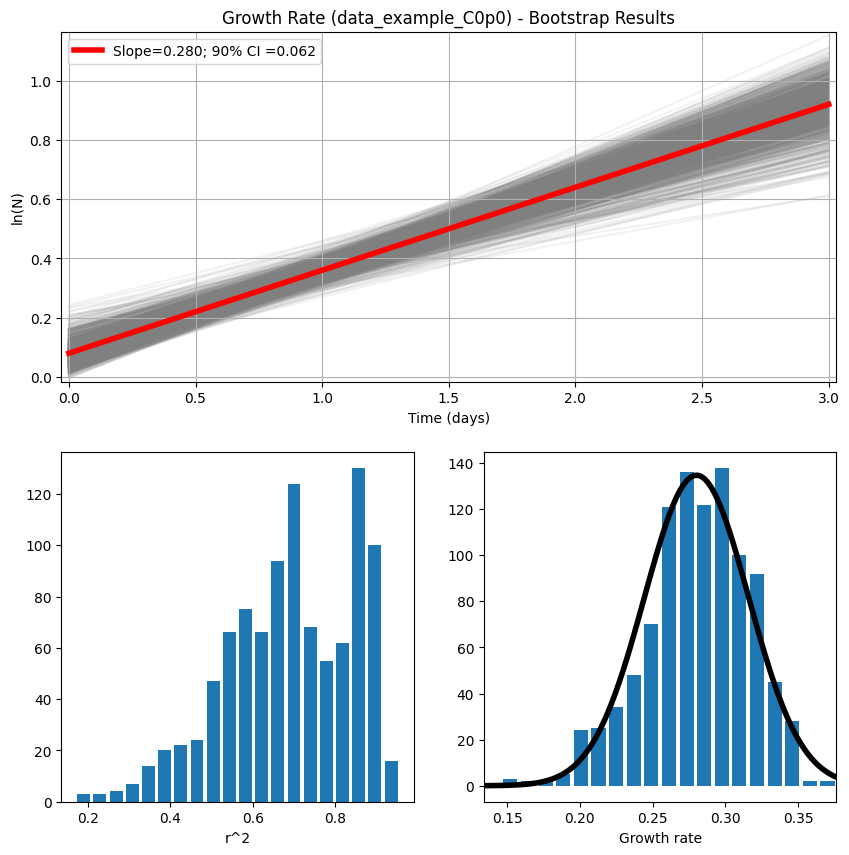

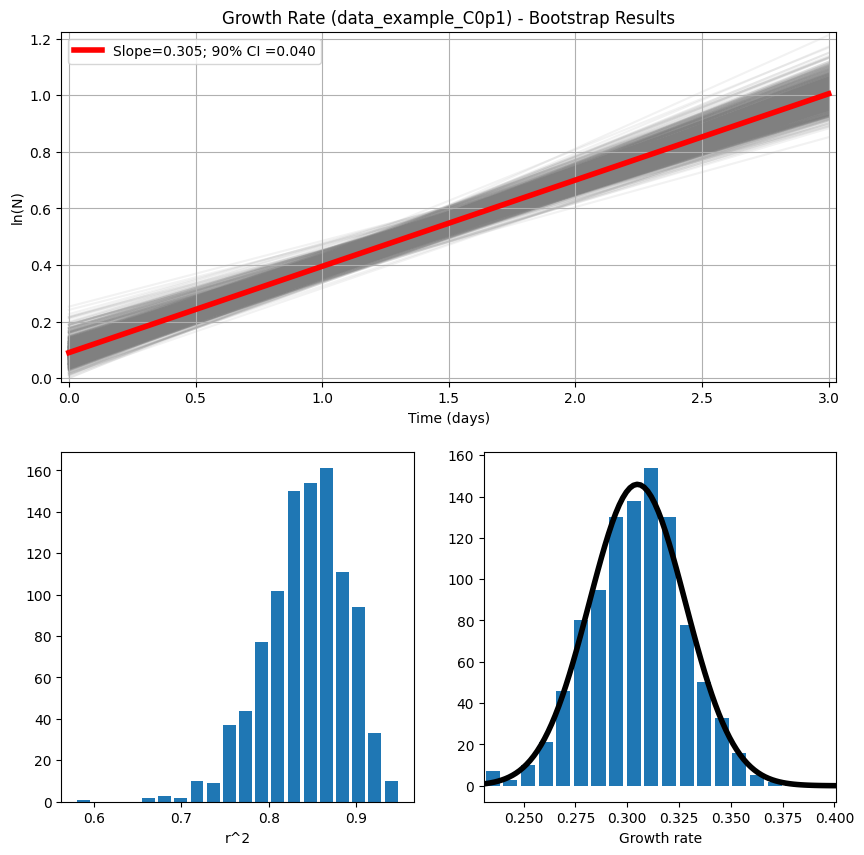

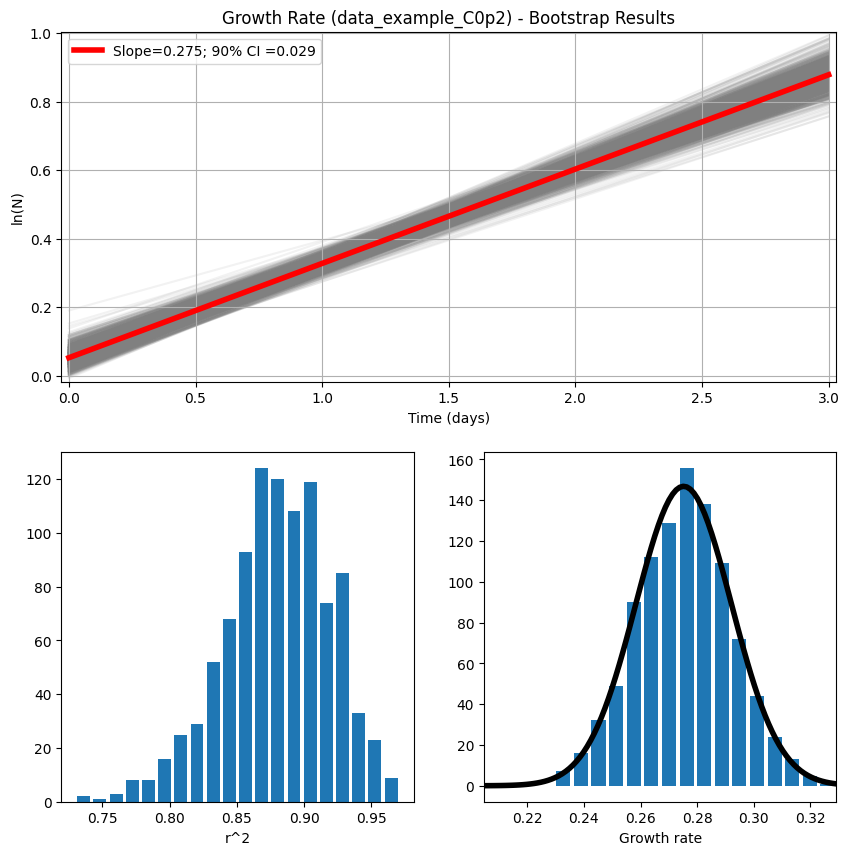

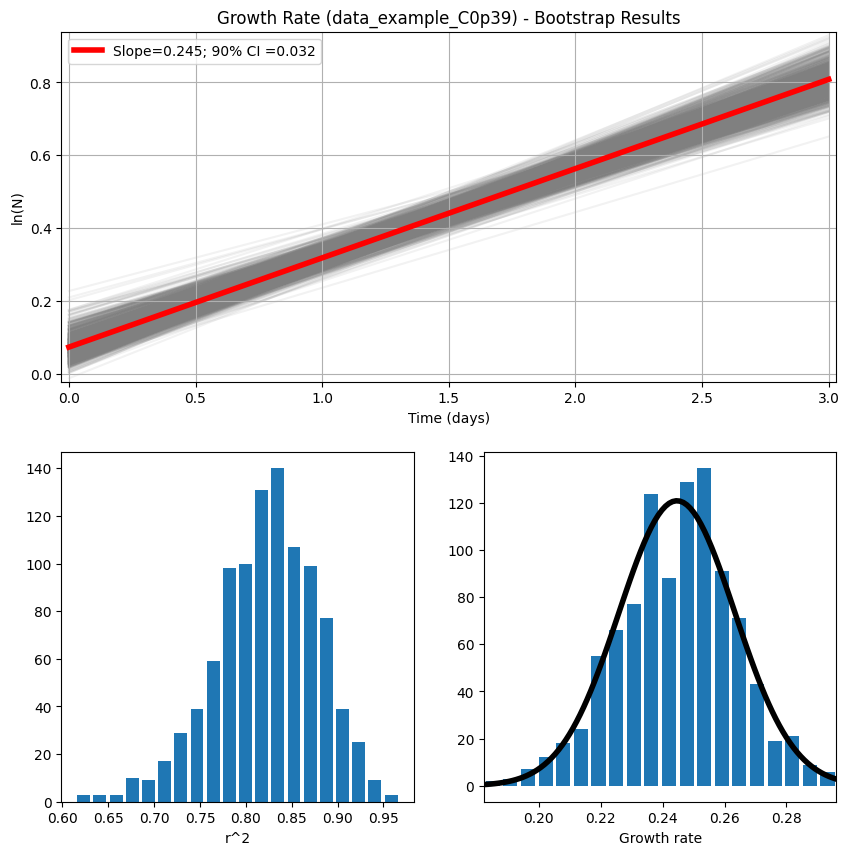

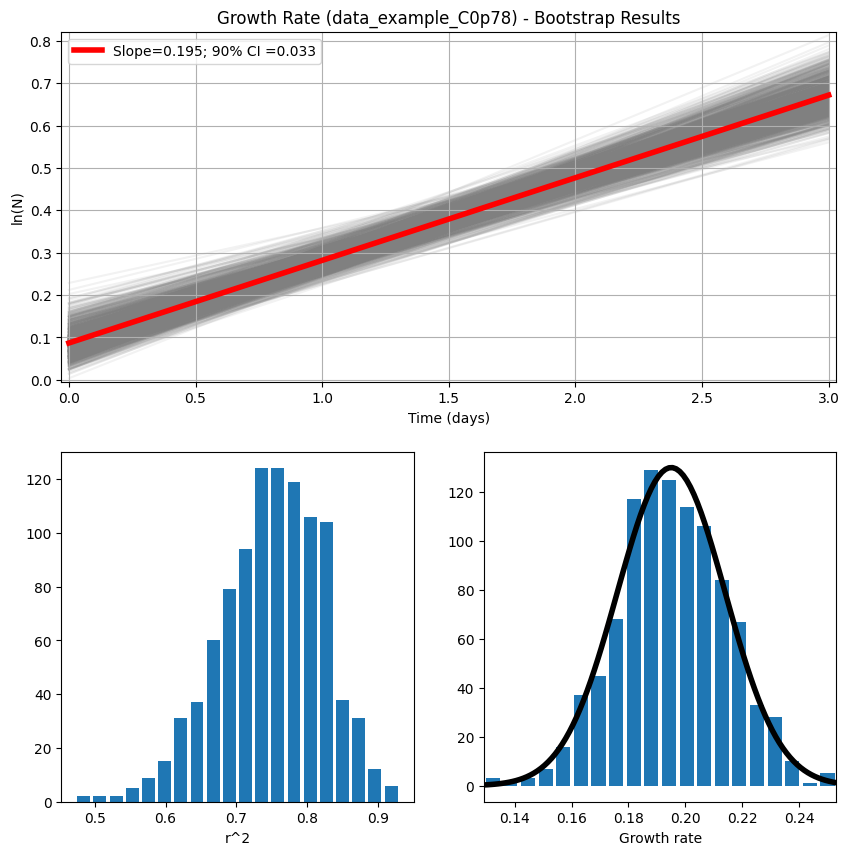

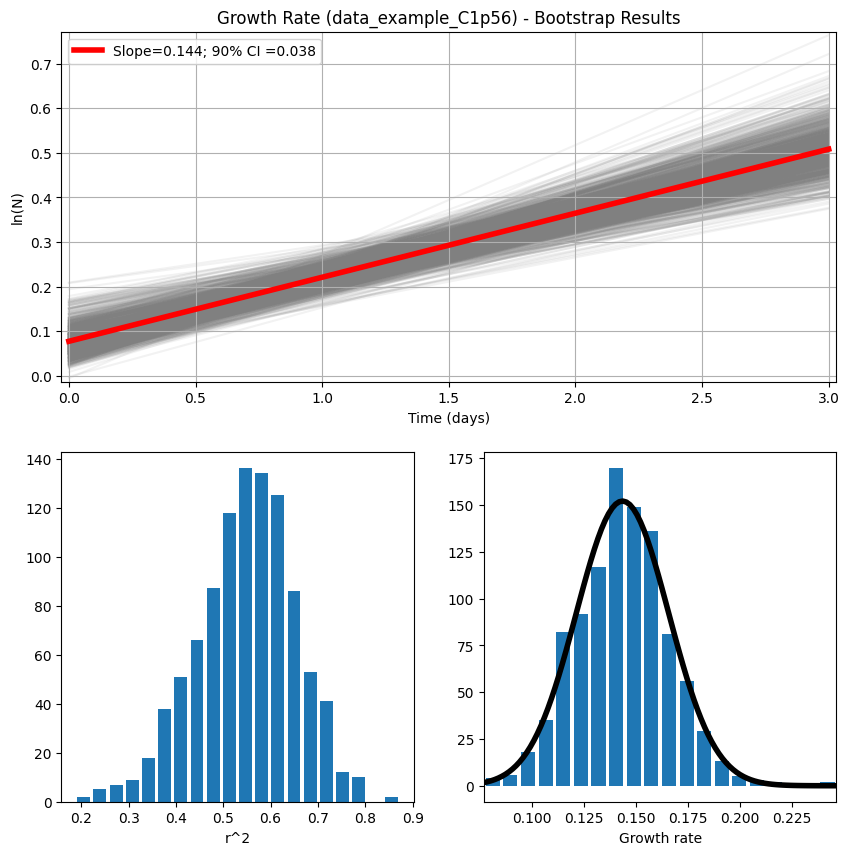

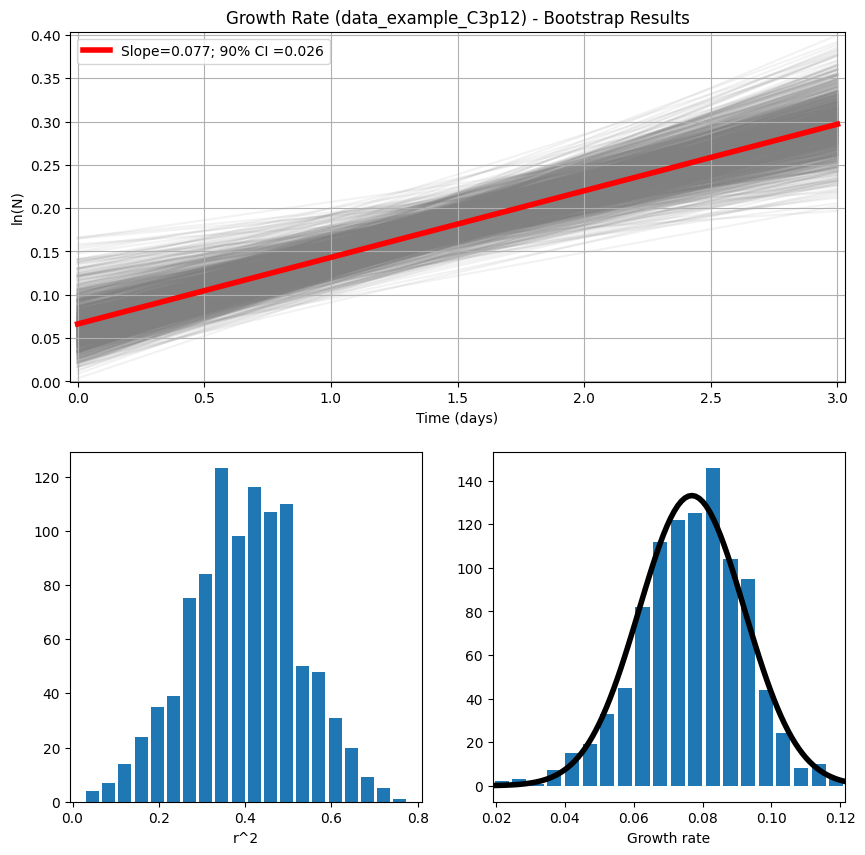

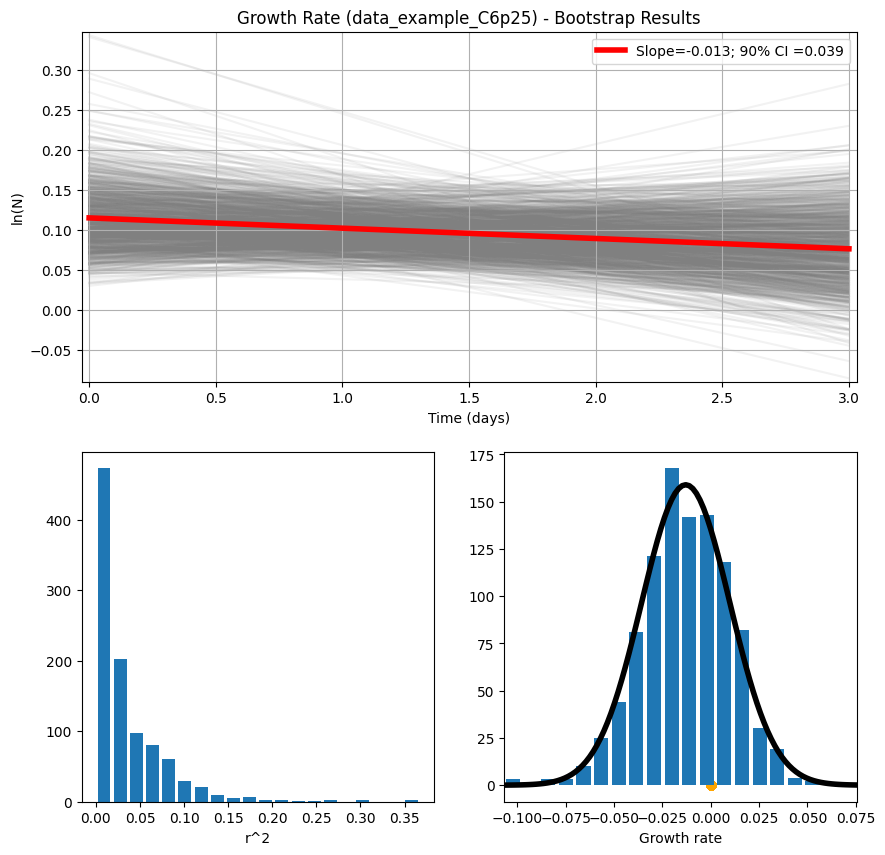

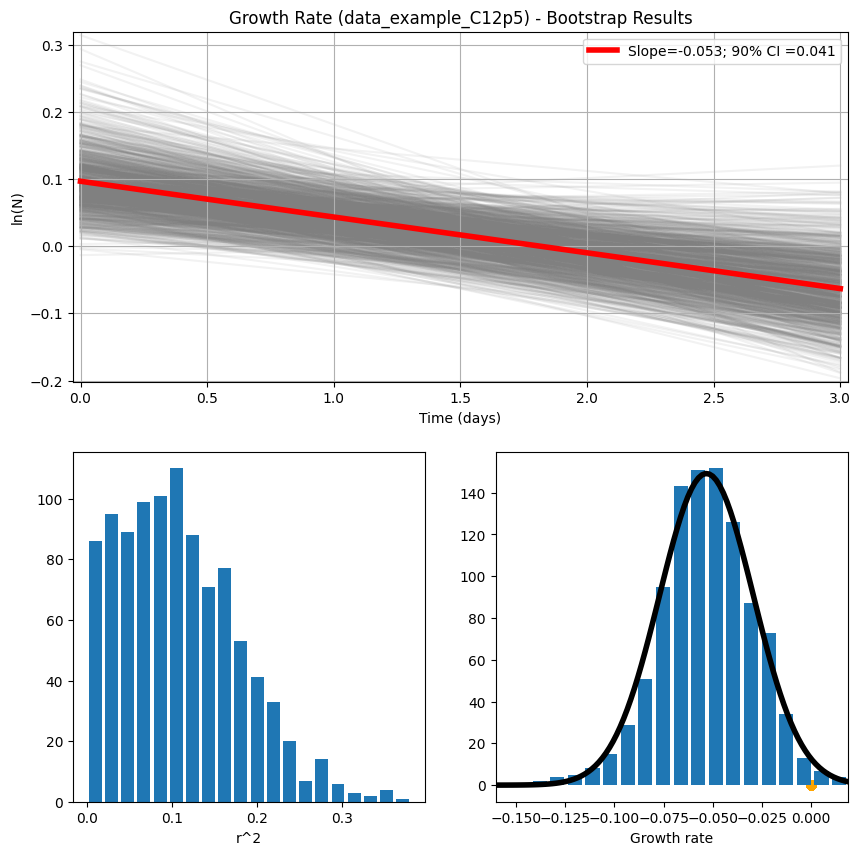

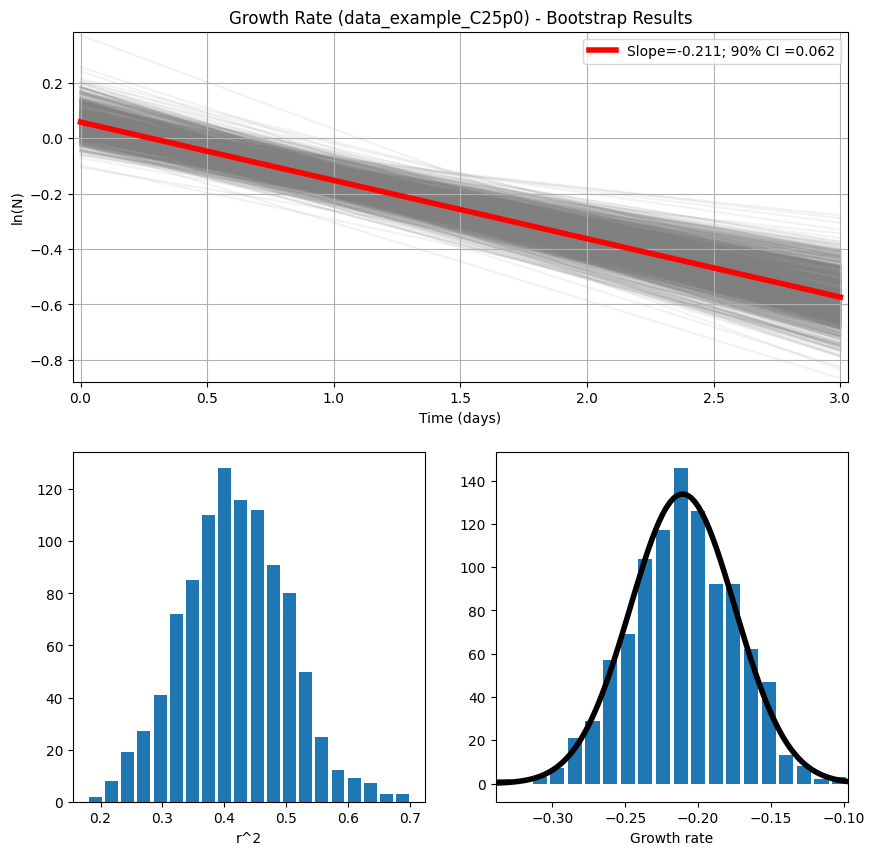

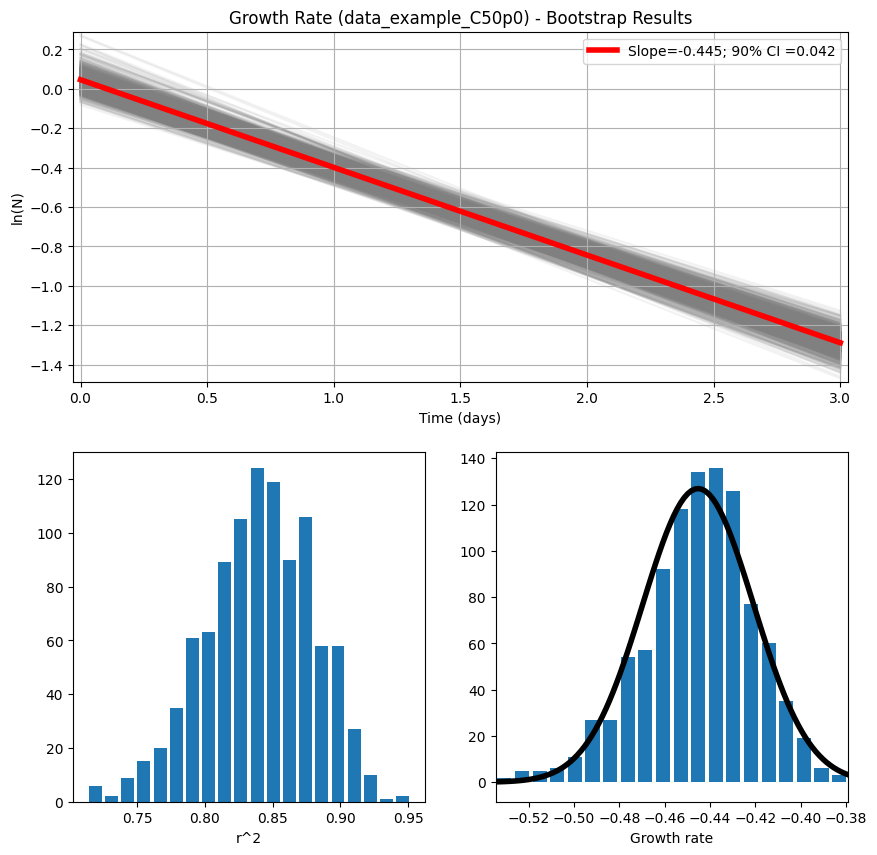

In [13]:
# Create a time array for plotting
time = [i for i in range(n_times) for _ in range(n_exp)]
X = np.array(time).reshape(-1, 1)

n_boot = 1000  # Number of bootstrap iterations

name = filename[:-5]
slopes=[]
err_slopes=[]
for i_C in range(len(concentr)):
    print('i_c:', i_C,'Concentr:',concentr[i_C])
    y = logs_C_t[i_C]

    concent_str = str(np.round(concentr[i_C], 2))
    name_C = name + '_C'+ concent_str.replace('.','p')
    print(name_C)

    # Calculate slope and error using bootstrap
    slope_i, error_slope_i = calculate_growth_rate_bootstrap(X, y, n_boot,  name_C, True)

    slopes.append(slope_i)
    err_slopes.append(error_slope_i)

# Save the results to an Excel file
export_growth_rates_to_excel(concentr, slopes, err_slopes, name)